# Baseline Linear Regression for the number of passengers

## Import
Just import the necessary modules.

In [1]:
!pip install hijri-converter


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pathlib import Path
import sys
import os

ROOT_DIR = Path().resolve().parent
sys.path.append(str(ROOT_DIR))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
#from hijri_converter import Gregorian
import joblib
#import importlib
#importlib.reload(features_utils)
from scripts.features_utils import get_features_lr, select_features_lr, get_hijri_info, r2_score_real, get_data



## Pull from database
The data is originally agreggated by service and class. There is two possible approaches for this linear regression, which are aggregate by date or by week. The later would result in a simpler model, and likely better final score, but give us less information. 
For that, it is better to start aggregating by date, and check the results. Since the result after trying different options is good enough, I prefer to keep this model.
The aggregation selected is done directly when pulling the information from the database.

In [3]:
# pull the data. the aggregation data is per day
data = get_data()

if data is None:
    #there was an error fetching the data. exiting
    sys.exit("Couldn't open data from database or file. Aborting.")

In [4]:
# Exploratory
data.head()

,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,day_category,price_mix_ratio
0,MAK-MAD,2021,53,2022-01-01,2579,12,419576.00,451077.0000,960687.672,Christmas,1.12900348972469949593
1,MAK-MAD,2022,1,2022-01-02,2038,12,343511.50,374778.0000,771785.126,Christmas,1.12644749754661432777
2,MAK-MAD,2022,1,2022-01-03,1900,12,320459.00,345114.5000,730788.374,Christmas,1.14226315789473684211
3,MAK-MAD,2022,1,2022-01-04,1810,12,306953.00,329255.0000,674187.758,Christmas,1.17303867403314917127
4,MAK-MAD,2022,1,2022-01-05,2440,14,395531.00,422114.0000,936571.790,Christmas,1.14508196721311475410


## Prepare data
Here the features are prepared.<br>
First of all the numerical features are standarized to better evaluate its importance when checking the coefficients.<br>
Calculate the Yield, which is the revenue / passengers * km, which evaluate the amount paid by the customer, weighted by the kilometers travelled.<br>
Create a dummy for the period of the service. Initially was designed by monthes, but since the months can vary due to overlap of gregorian and hijri calendars, later was fine tuned using weeks. which improved the final score.<br>
To model the peak seasons (Ramadan, and Hajj) dummy variables were created for each day of the corresponding Hijri months (Ramadan, and Dul Hijja)<br>
Due to the number of variables (specially dummy ones), Lasso approach was tested, without any improvement.<br>
Yield was decided to remove from the model, since was not improving the model, plus giving counterintuitive positive coefficient. It is expected that a increase of prices would drop somehow the demand, but the effect was not properly captured, probably because some multicolinearity with the number of service and high demand (since the prices are dynamic, increase of demand push up the prices as well, likely enforcing the model to capture that as a positive relation).<br>
Finally, intuition tells that the number of services should decrease its effect in the number of passenger as they increase, since the number of passenger added per each new service should disminish. Nonetheless, after trying to model that feature using a polyomial relation, the final score did not improve, and the coefficient for the squared parameter was positive, leading to the misconducting conclusion that big number of services would yield even greater number of passenger. That could be because the number of services have increased greatly from one year to another, because the service is rather new and thus is growing so much. Possibily, the model is mistaking the natural growth of the demand as part of the impact of the number of services. Once the market has matured enough, and more data is available, the model can be reviewed to correctly model those parameters. 



## Create Features

In [5]:
df_r1 = get_features_lr(data)

#replicate the dummies to get the headers to be used during the test
period_dummies = pd.get_dummies(data['train_week_num'], prefix="Week", drop_first=True)
weekday_dummies = pd.get_dummies(pd.to_datetime(data['train_departure_date_short']).dt.dayofweek, prefix="Weekday", drop_first=True)
data["hijri_day_tag"] = data["train_departure_date_short"].apply(get_hijri_info)
hijri_dummies = pd.get_dummies(data["hijri_day_tag"], prefix="", prefix_sep="")
hijri_dummies = hijri_dummies.drop(columns=["None"], errors="ignore")

## Parameter for prices
The prices are not fixed, change over time due to political reasons, or marketing targets. The variations are not done with the same strategy each time (sometimes a % of reduction is applied and other times remove the effect of the dynamic prices for all the service, for instance).<br>
Since is difficult to feature this effect, after some tries I decided to keep a simple ratio which is the price paid for a ticket (or group or tickets, or the amount for all day) compared with the price that the same ticket could have yield in a standard price scenario (dynamic prices, standard price mix, regular prices). The proportion between this two magnitudes is what I call the ratio of prices (ratio_prices)<br>
Later on, I try to model the effect of the "prices" (that is, the ratio of prices mentioned before) using a log-log relation to model a negative exponential relation between the number of passengers and the prices.<br>

In [6]:
#df_prices = pd.DataFrame({'ratio':data['revenue'] / data['revenue_without_promotion']})
#df_prices.index = df_r1.index
#df_r1['ratio_prices'] = df_prices['ratio']

In [7]:
# estimation of price elasticity
# log-log
X = np.log(df_r1['price_ratio'].astype(float))
y = np.log(df_r1['passengers'].astype(float))

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     87.12
Date:                Tue, 13 May 2025   Prob (F-statistic):           4.88e-20
Time:                        08:48:41   Log-Likelihood:                -960.56
No. Observations:                1186   AIC:                             1925.
Df Residuals:                    1184   BIC:                             1935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.9860      0.019    476.923      

## Select Features
X and Y are selected in this step.<br>
Different combination of features have been tested to achieve the best results.<br>
The target variable would be the number of passenger adjusted using the previous relation of prices: the goal is to predict the passengers that we could get with standard prices, the standard demand regardless of price variation<br>

In [8]:
#select columns
features = ['train_year'
            #,'yield_std'
            ,'number_of_services_std'
           ] + period_dummies.columns.tolist() + weekday_dummies.columns.tolist() + hijri_dummies.columns.tolist() #+ poly_df.columns.tolist()
target = 'passengers_adjusted'

# calculate the passengers adjusted to the level of prices
elasticity = -.6754 # the coefficient in the log log model 
df_r1['passengers_adjusted'] = df_r1['passengers'].astype(float) * (1/(df_r1['price_ratio'].astype(float) ** elasticity))

#select data
X = df_r1[features]
y = df_r1[target]

## Data Cleaning
During the first attemps there was some empty data due to incomplete information for future days (i.e. if the data is updated at 31 aug, there is already data for bookings made for trains in septemeber, but those days are not yet finised). The situation was solved filtering the original data while fetching the information.

In [9]:
# check for NaN
X.isnull().any()
y.isnull().any() # initially true due to incomplete days

df_r1[y.isnull()] # empty now


,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,day_category,...,ramadan_29,ramadan_3,ramadan_30,ramadan_4,ramadan_5,ramadan_6,ramadan_7,ramadan_8,ramadan_9,passengers_adjusted


In [10]:
X.head()

,train_year,number_of_services_std,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7,Week_8,Week_9,...,ramadan_28,ramadan_29,ramadan_3,ramadan_30,ramadan_4,ramadan_5,ramadan_6,ramadan_7,ramadan_8,ramadan_9
0,0,-1.686717,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,-1.686717,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,-1.686717,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,-1.686717,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,-1.506578,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The data is divided in order to test its results, taking 20% of the data as test. The random seed is fixed in order to be able to compare the effect of different modifications in the features and the model.<br>
Later on, when crossing test with other models, the random seed should be removed.

## Split the data
Split manually to avoid shuffling. This approach is intended to be able to compare with other models (such as Arima) that are intended for time series.<br>

In [11]:
# Split between training and test
n = len(df_r1)
train_size = int(n * 0.8)
test_size = n - train_size

y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]


## Training
Train the model and evaluate its results.<br>
The first approach is giving a decent result, but aftewards I try to evaluate how good is the combined model linear regression + adjustment of prices to predict the real passengers.<br>
The final result is that the adjustment of prices distort greatly the result, giving an awful evaluation.<br>
It is decided to go with the real passengers as target and the prices as another feature. Even though the relation between prices and passengers is not lineal, the final result is better, and good enough for a baseline <br>

In [12]:
# Create a pipeline: scale first, then fit the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [13]:
# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.5971867988174513
Mean Absolute Error: 1852.923681277044
Mean Squared Error: 4601139.118790578


In [14]:
# evaluation after regularization of prices
print("R² Score:", r2_score_real(y_test, y_pred, df_r1['price_ratio'][-test_size:] , elasticity)) 

R² Score: -0.410817463451852


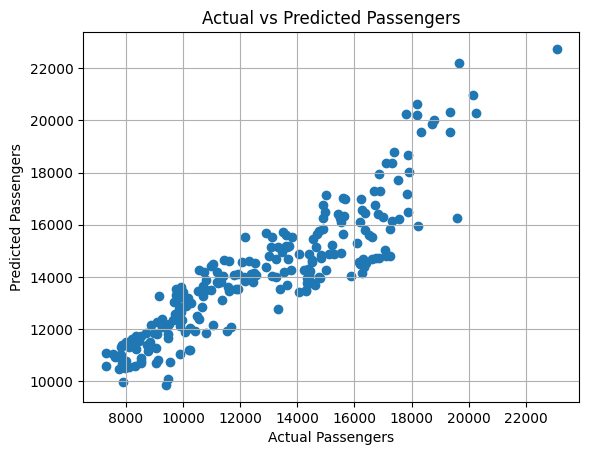

In [15]:
# plot adjusted passengers
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Passengers")
plt.ylabel("Predicted Passengers")
plt.title("Actual vs Predicted Passengers")
plt.grid(True)
plt.show()

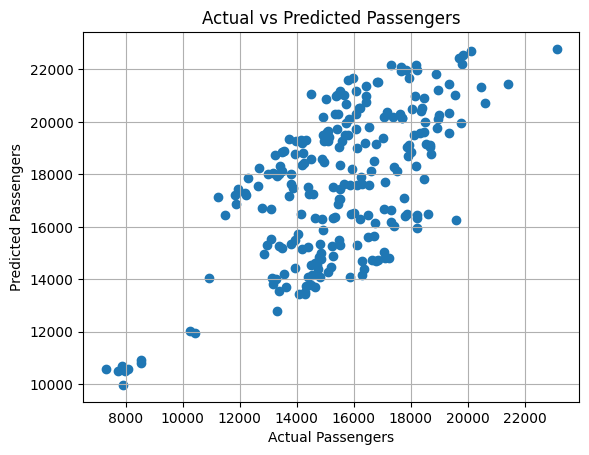

In [16]:
# plot real passengers
plt.scatter(
    y_test * ((df_r1['price_ratio'][-test_size:].astype(float)) ** float(elasticity)), 
    y_pred* ((df_r1['price_ratio'][-test_size:].astype(float)) ** float(elasticity)))
plt.xlabel("Actual Passengers")
plt.ylabel("Predicted Passengers")
plt.title("Actual vs Predicted Passengers")
plt.grid(True)
plt.show()

## Training without price adjustment
As mentioned, the ratio of prices is added as feature, while the target is swifted to the real passengers.<br>

In [17]:
#select columns
features = ['train_year'
            #,'yield_std'
            ,'number_of_services_std',
            'price_ratio',
           ] + period_dummies.columns.tolist() + weekday_dummies.columns.tolist() + hijri_dummies.columns.tolist() #+ poly_df.columns.tolist()
target = 'passengers'

#select data
X = df_r1[features]
y = df_r1[target]

In [18]:
# Split between training and test
n = len(df_r1)
train_size = int(n * 0.8)
test_size = n - train_size

y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

In [19]:
#model 
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

In [20]:
# evaluation
print("R² Score:", r2_score(y_test, y_pred)) 

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score: 0.6576505266974559
Mean Absolute Error: 1142.605469878377
Mean Squared Error: 2289822.02647827


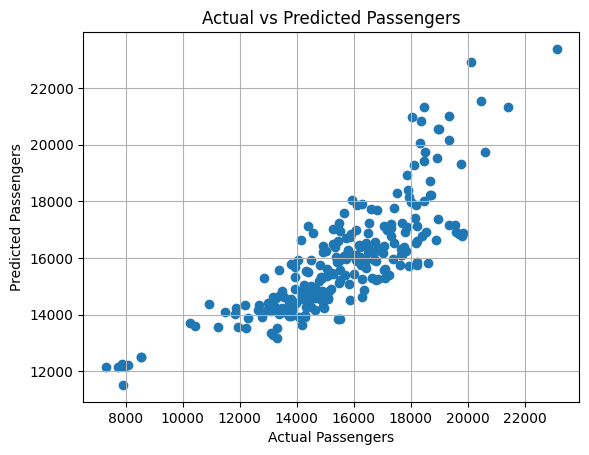

In [21]:
# plot adjusted passengers
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Passengers")
plt.ylabel("Predicted Passengers")
plt.title("Actual vs Predicted Passengers")
plt.grid(True)
plt.show()

## Outliers
The outliners were investigated to try to understand patterns that were lost during the initial design, or to detect some anomality that should be removed. No pattern was detected at the end of the process.<br>
During intermediate iterations, this steps helped to detect features, suchs as prices variation and special days. <br>
At the end of the process, most of those outliers are railway incidents, thus reducing the number of passengers due to causes not related to demand.<br>

In [22]:
# lets investigate the outliers that appear on the chart

# Add predictions and residuals to your dataframe
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
})
results["Residual"] = abs(results["Actual"].astype(float) - results["Predicted"])

# Sort by largest residuals
top_outliers = results.sort_values(by="Residual", ascending=False).head(30)
outlier_indices = top_outliers.index.tolist()
df_r1.loc[outlier_indices]


,corridor_name,train_year,train_week_num,train_departure_date_short,passengers,number_of_services,revenue,revenue_without_promotion,passengers_km,day_category,...,ramadan_29,ramadan_3,ramadan_30,ramadan_4,ramadan_5,ramadan_6,ramadan_7,ramadan_8,ramadan_9,passengers_adjusted
975,MAK-MAD,3,36,2024-09-02,7308,36,1073767.05,1074853.9000,2891517.658,Autumn,...,False,False,False,False,False,False,False,False,False,7303.008270
982,MAK-MAD,3,37,2024-09-09,7743,36,1159397.60,1160016.3000,3089151.262,Autumn,...,False,False,False,False,False,False,False,False,False,7740.210516
976,MAK-MAD,3,36,2024-09-03,7881,36,1198365.17,1199833.2000,3189006.650,Autumn,...,False,False,False,False,False,False,False,False,False,7874.486076
974,MAK-MAD,3,36,2024-09-01,7874,36,1164940.10,1166698.8000,3109818.418,Autumn,...,False,False,False,False,False,False,False,False,False,7865.981451
981,MAK-MAD,3,37,2024-09-08,7965,36,1219452.20,1221535.9000,3191680.650,Autumn,...,False,False,False,False,False,False,False,False,False,7955.820985
983,MAK-MAD,3,37,2024-09-10,8103,36,1236991.20,1237927.4000,3262971.584,Autumn,...,False,False,False,False,False,False,False,False,False,8098.860635
984,MAK-MAD,3,37,2024-09-11,8528,36,1283441.00,1285062.7000,3380792.956,Autumn,...,False,False,False,False,False,False,False,False,False,8520.729849
977,MAK-MAD,3,36,2024-09-04,8542,36,1278992.45,1281504.8000,3367892.644,Autumn,...,False,False,False,False,False,False,False,False,False,8530.685931
979,MAK-MAD,3,36,2024-09-06,7895,32,1182982.70,1183815.2000,3067964.280,Autumn,...,False,False,False,False,False,False,False,False,False,7891.249725
980,MAK-MAD,3,36,2024-09-07,10247,38,1586596.05,1587252.4000,4050114.892,Autumn,...,False,False,False,False,False,False,False,False,False,10244.137955


## Coefficient Check
Except the cases mentioned above, the rest of the coeffiients match the prior knowledge of the market:
- Main features are meaningfull
- The special days of Ramadan and Hajj have high coefficients.
- The high demand periods have positive meaningful coefficients for their weeks, and the contrary for the low demand periods.

In [23]:
# After fitting the model
coefficients = pd.Series(model.coef_, index=X.columns)

# Sort by absolute importance
coefficients_sorted = coefficients.abs().sort_values(ascending=False)

# Display with signs
print(coefficients.loc[coefficients_sorted.index])


ramadan_20      5157.332148
dul_hijja_7     4890.393169
ramadan_25      4802.670847
price_ratio    -4540.436914
ramadan_19      4453.771804
                   ...     
Week_5           -90.231402
Weekday_1         89.905277
dul_hijja_18     -66.649163
Weekday_6         26.382388
Week_39            2.917505
Length: 121, dtype: float64


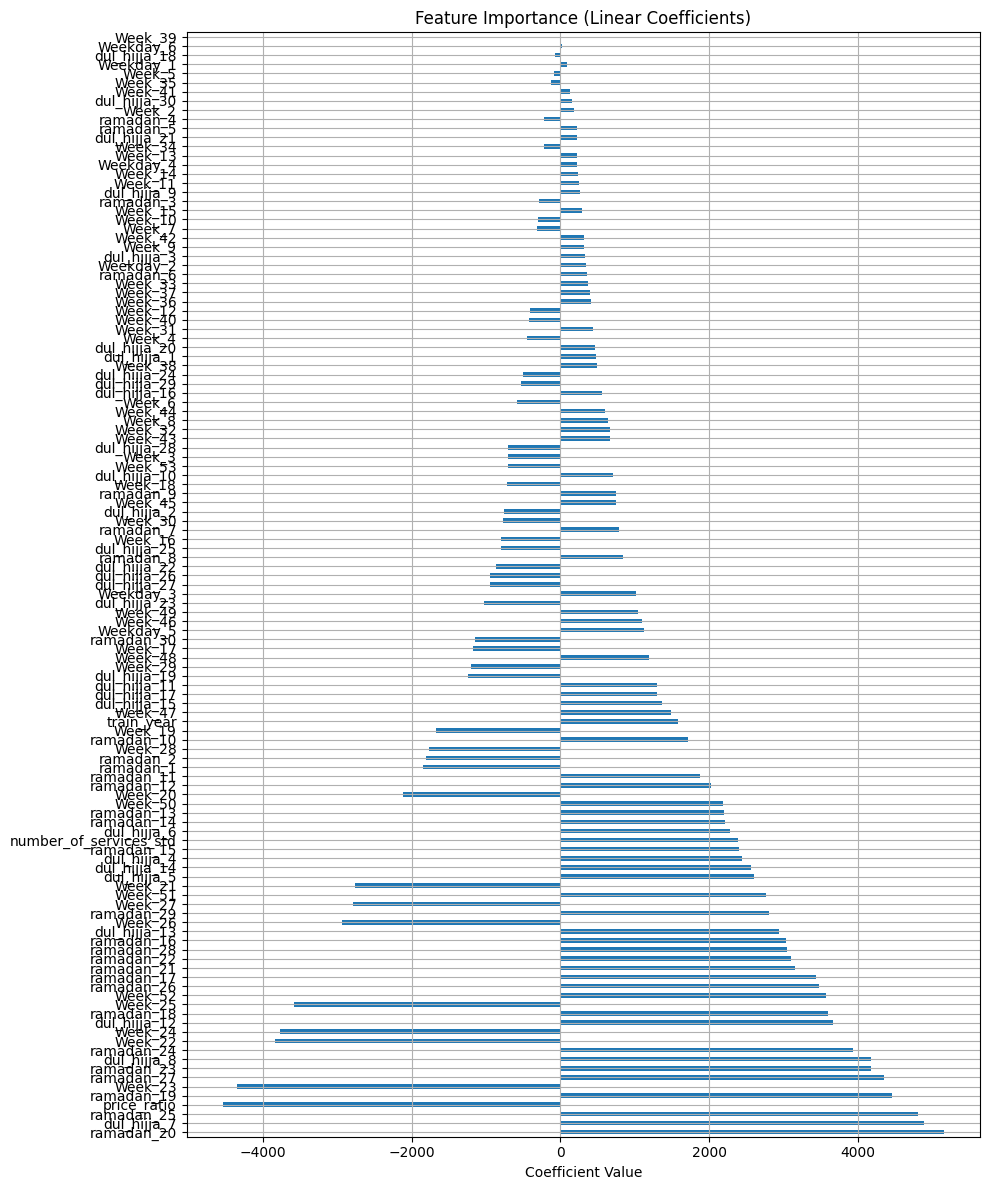

In [24]:
coefficients.loc[coefficients_sorted.index].plot(kind='barh', figsize=(10, 12))
plt.title("Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()


## Export
Export the model to a file, to later on show together the rest of the models. <br>
The final file is a pipeline that, taken the original data as a input, create the necessary features (or even more features due to previous steps discarded) and later on select only the features required for the model.<br>
Both the pipeline and the selected features are stored.<br>

In [29]:
#save the features to be used by the select_features function
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

with open(os.path.join(ROOT_DIR, "features", "features_lr.json"), "w") as f:
    json.dump(model.feature_names_in_.tolist(), f)
    
# create a pipeline with the model and the feature engineering
pipeline = Pipeline([
    ('features', FunctionTransformer(get_features_lr, validate=False)),
    ('filter', FunctionTransformer(select_features_lr, validate=False)),
    ('model', model)
])

# save the pipeline
joblib.dump(pipeline, os.path.join(ROOT_DIR, "models", "pipeline_linear_regression.pkl"))


['C:\\Users\\Joan\\Documents\\jpnb\\models\\pipeline_linear_regression.pkl']

In [26]:
model.feature_names_in_.tolist()

['train_year',
 'number_of_services_std',
 'price_ratio',
 'Week_2',
 'Week_3',
 'Week_4',
 'Week_5',
 'Week_6',
 'Week_7',
 'Week_8',
 'Week_9',
 'Week_10',
 'Week_11',
 'Week_12',
 'Week_13',
 'Week_14',
 'Week_15',
 'Week_16',
 'Week_17',
 'Week_18',
 'Week_19',
 'Week_20',
 'Week_21',
 'Week_22',
 'Week_23',
 'Week_24',
 'Week_25',
 'Week_26',
 'Week_27',
 'Week_28',
 'Week_29',
 'Week_30',
 'Week_31',
 'Week_32',
 'Week_33',
 'Week_34',
 'Week_35',
 'Week_36',
 'Week_37',
 'Week_38',
 'Week_39',
 'Week_40',
 'Week_41',
 'Week_42',
 'Week_43',
 'Week_44',
 'Week_45',
 'Week_46',
 'Week_47',
 'Week_48',
 'Week_49',
 'Week_50',
 'Week_51',
 'Week_52',
 'Week_53',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'dul_hijja_1',
 'dul_hijja_10',
 'dul_hijja_11',
 'dul_hijja_12',
 'dul_hijja_13',
 'dul_hijja_14',
 'dul_hijja_15',
 'dul_hijja_16',
 'dul_hijja_17',
 'dul_hijja_18',
 'dul_hijja_19',
 'dul_hijja_2',
 'dul_hijja_20',
 'dul_hijja_21',
 'dul_